In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os, shutil
import time
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

In [3]:
# Load the data
train = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')

sample_sub = pd.read_csv('sample_submission.csv')

variable_def = pd.read_csv('VariableDefinitions.csv')

In [4]:
# Preview the data
print('Train columns:', train.columns)
print('Shape of training data:', train.shape)
print('Shape of test set:', test.shape)
train.head()

Train columns: Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')
Shape of training data: (400000, 19)
Shape of test set: (100000, 18)


,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [5]:
train.set_index('user_id', inplace=True)
test.set_index('user_id', inplace=True)

In [6]:
train.isnull().sum()

REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [7]:
train['REGION'].isnull().sum()

157520

In [8]:
train['REGION'].value_counts()

DAKAR          95517
THIES          33374
SAINT-LOUIS    22125
LOUGA          18513
KAOLACK        18042
DIOURBEL       12576
TAMBACOUNDA    10273
KAFFRINE        8181
KOLDA           7204
FATICK          6638
MATAM           5255
ZIGUINCHOR      4012
SEDHIOU          589
KEDOUGOU         181
Name: REGION, dtype: int64

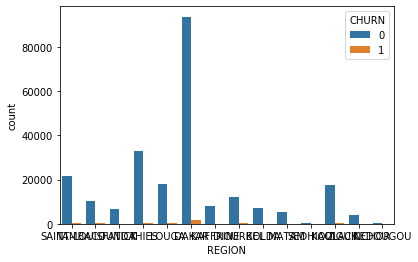

In [9]:
sns.countplot(x = 'REGION', hue='CHURN', data = train)

In [10]:
train['REGION'] = train['REGION'].fillna('DAKAR')
test['REGION'] = test['REGION'].fillna('DAKAR')

In [11]:
encode_text_dummy(train, name='REGION')
encode_text_dummy(test, name='REGION')


In [12]:
def enco(data):
    if data == 'K > 24 month':
        out = 1
    else:
        out = 0
    return out

In [13]:
train['TENURE'] = train['TENURE'].apply(enco)
test['TENURE'] = test['TENURE'].apply(enco)

In [14]:
train['MONTANT'] = train['MONTANT'].fillna(train['MONTANT'].mode()[0])
test['MONTANT'] = test['MONTANT'].fillna(test['MONTANT'].mode()[0])

In [15]:
def bin_montant(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [16]:
montant = bin_montant(train['MONTANT'], train['MONTANT'].min(), train['MONTANT'].max(), 30)
montant1 = bin_montant(test['MONTANT'], test['MONTANT'].min(), test['MONTANT'].max(), 30)

{'0': (0, 7551), '1': (7551, 15102), '2': (15102, 22653), '3': (22653, 30204), '4': (30204, 37755), '5': (37755, 45306), '6': (45306, 52857), '7': (52857, 60408), '8': (60408, 67959), '9': (67959, 75510), '10': (75510, 83061), '11': (83061, 90612), '12': (90612, 98163), '13': (98163, 105714), '14': (105714, 113265), '15': (113265, 120816), '16': (120816, 128367), '17': (128367, 135918), '18': (135918, 143469), '19': (143469, 151020), '20': (151020, 158571), '21': (158571, 166122), '22': (166122, 173673), '23': (173673, 181224), '24': (181224, 188775), '25': (188775, 196326), '26': (196326, 203877), '27': (203877, 211428), '28': (211428, 218979), '29': (218979, 226530), '30': (226530, 226551)}
{'0': (0, 6715), '1': (6715, 13430), '2': (13430, 20145), '3': (20145, 26860), '4': (26860, 33575), '5': (33575, 40290), '6': (40290, 47005), '7': (47005, 53720), '8': (53720, 60435), '9': (60435, 67150), '10': (67150, 73865), '11': (73865, 80580), '12': (80580, 87295), '13': (87295, 94010), '14':

In [17]:
train['MONTANT_BIN'] = montant
test['MONTANT_BIN'] = montant1

train.drop('MONTANT', inplace=True, axis=1)
test.drop('MONTANT', inplace=True, axis=1)

In [18]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out = 0
    return out

train['MONTANT_BIN'] = train['MONTANT_BIN'].apply(enco)
test['MONTANT_BIN'] = test['MONTANT_BIN'].apply(enco)

In [19]:
train['FREQUENCE_RECH'] = train['FREQUENCE_RECH'].fillna(train['FREQUENCE_RECH'].mean())
test['FREQUENCE_RECH'] = test['FREQUENCE_RECH'].fillna(test['FREQUENCE_RECH'].mean())


In [20]:
train['FREQUENCE_RECH'] = train['FREQUENCE_RECH'].round()
test['FREQUENCE_RECH'] = test['FREQUENCE_RECH'].round()

In [21]:
def bin_freq_rech(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out

In [22]:
freq_out = bin_freq_rech(train['FREQUENCE_RECH'], 1, 133, 10)
freq_out1 = bin_freq_rech(test['FREQUENCE_RECH'], 1, 120, 9)

{'0': (0, 13), '1': (13, 26), '2': (26, 39), '3': (39, 52), '4': (52, 65), '5': (65, 78), '6': (78, 91), '7': (91, 104), '8': (104, 117), '9': (117, 130), '10': (130, 134)}
{'0': (0, 13), '1': (13, 26), '2': (26, 39), '3': (39, 52), '4': (52, 65), '5': (65, 78), '6': (78, 91), '7': (91, 104), '8': (104, 117), '9': (117, 121)}


In [23]:
train['FREQ_BIN'] = freq_out
test['FREQ_BIN'] =freq_out1

In [24]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out =0
    return out

In [25]:
train['FREQ_BIN'] = train['FREQ_BIN'].apply(enco)
test['FREQ_BIN'] = test['FREQ_BIN'].apply(enco)

In [26]:
train.drop('FREQUENCE_RECH', inplace=True, axis=1)
test.drop('FREQUENCE_RECH', inplace=True, axis=1)

In [27]:
train['REVENUE'] = train['REVENUE'].fillna(train['REVENUE'].mean())
test['REVENUE'] = test['REVENUE'].fillna(test['REVENUE'].mean())

In [28]:
train['REVENUE'] = np.log1p(train['REVENUE'])
test['REVENUE'] = np.log1p(test['REVENUE'])

In [29]:
train['ARPU_SEGMENT'] = train['ARPU_SEGMENT'].fillna(train['ARPU_SEGMENT'].mean())
test['ARPU_SEGMENT'] = test['ARPU_SEGMENT'].fillna(test['ARPU_SEGMENT'].mean())

In [30]:
train['ARPU_SEGMENT'] = np.log1p(train['ARPU_SEGMENT'])
test['ARPU_SEGMENT'] = np.log1p(test['ARPU_SEGMENT'])

In [31]:
train['FREQUENCE'] = train['FREQUENCE'].fillna(train['FREQUENCE'].median())
test['FREQUENCE'] = test['FREQUENCE'].fillna(test['FREQUENCE'].median())

In [32]:
def bin_freq(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [33]:
freq1 = bin_freq(train['FREQUENCE'], train['FREQUENCE'].min(), train['FREQUENCE'].max(), 9)
freq2 = bin_freq(test['FREQUENCE'], test['FREQUENCE'].min(), test['FREQUENCE'].max(), 9)

{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 70), '7': (70, 80), '8': (80, 90), '9': (90, 92)}
{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 70), '7': (70, 80), '8': (80, 90), '9': (90, 92)}


In [34]:
train['FREQ_BIN'] = freq1
test['FREQ_BIN'] = freq2

In [35]:
def enco(data):
    if data == 0:
        out = 1
    elif data == 1:
        out = 1
    else:
        out = 0
    return out

In [36]:
train['FREQ_BIN'] = train['FREQ_BIN'].apply(enco)
test['FREQ_BIN'] = test['FREQ_BIN'].apply(enco)

In [37]:
train.drop('FREQUENCE', inplace=True, axis =1)
test.drop('FREQUENCE', inplace=True, axis =1)

In [38]:
train['DATA_VOLUME'] = train['DATA_VOLUME'].fillna(train['DATA_VOLUME'].median())
test['DATA_VOLUME'] = test['DATA_VOLUME'].fillna(test['DATA_VOLUME'].median())

In [39]:
train['DATA_VOLUME'] = np.log1p(train['DATA_VOLUME'])
test['DATA_VOLUME'] = np.log1p(test['DATA_VOLUME'])

In [40]:
train['ON_NET'] = train['ON_NET'].fillna(train['ON_NET'].median())
test['ON_NET'] = test['ON_NET'].fillna(test['ON_NET'].median())

In [41]:
train['ON_NET']= np.log1p(train['ON_NET'])
test['ON_NET']= np.log1p(test['ON_NET'])


In [42]:
train['ORANGE'] = train['ORANGE'].fillna(train['ORANGE'].median())
test['ORANGE'] = test['ORANGE'].fillna(test['ORANGE'].median())

In [43]:
train['ORANGE'] = np.log1p(train['ORANGE'])
test['ORANGE'] = np.log1p(test['ORANGE'])

In [44]:
def bin_orange(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [45]:
orange = bin_orange(train['ORANGE'], train['ORANGE'].min(), train['ORANGE'].max(), 8)
orange1 = bin_orange(test['ORANGE'], test['ORANGE'].min(), test['ORANGE'].max(), 8)

{'0': (0, 1), '1': (1, 2), '2': (2, 3), '3': (3, 4), '4': (4, 5), '5': (5, 6), '6': (6, 7), '7': (7, 8), '8': (8, 9)}
{'0': (0, 1), '1': (1, 2), '2': (2, 3), '3': (3, 4), '4': (4, 5), '5': (5, 6), '6': (6, 7), '7': (7, 8), '8': (8, 9)}


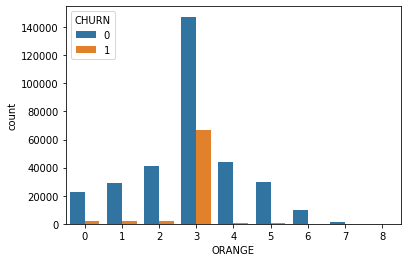

In [46]:
train['ORANGE'] = orange
sns.countplot(x=train['ORANGE'], hue='CHURN', data=train)

In [47]:
train['TIGO'] = train['TIGO'].fillna(train['TIGO'].mean())
test['TIGO'] = test['TIGO'].fillna(test['TIGO'].mean())

In [48]:
train['TIGO'] = np.round(train['TIGO'])
test['TIGO'] = np.round(test['TIGO'])

In [49]:
def bin_tigo(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [50]:
tigo = bin_tigo(train['TIGO'], train['TIGO'].min(), train['TIGO'].max(), 10)
tigo1 = bin_tigo(test['TIGO'], test['TIGO'].min(), test['TIGO'].max(), 10)

{'0': (0, 275), '1': (275, 550), '2': (550, 825), '3': (825, 1100), '4': (1100, 1375), '5': (1375, 1650), '6': (1650, 1925), '7': (1925, 2200), '8': (2200, 2475), '9': (2475, 2750), '10': (2750, 2759)}
{'0': (0, 308), '1': (308, 616), '2': (616, 924), '3': (924, 1232), '4': (1232, 1540), '5': (1540, 1848), '6': (1848, 2156), '7': (2156, 2464), '8': (2464, 2772), '9': (2772, 3080), '10': (3080, 3084)}


In [51]:
train['TIGO'] = tigo
test['TIGO'] = tigo1

In [52]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out = 0
    return out

train['TIGO'] = train['TIGO'].apply(enco)
test['TIGO'] = test['TIGO'].apply(enco)

In [53]:
to_drop1 = ['ZONE1', 'ZONE2', 'MRG']

train.drop(to_drop1, inplace=True, axis=1)
test.drop(to_drop1, inplace=True, axis=1)

In [54]:
def bin_regu(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [55]:
regu = bin_regu(train['REGULARITY'], train['REGULARITY'].min(), train['REGULARITY'].max(), 6)
regu1 = bin_regu(test['REGULARITY'], test['REGULARITY'].min(), test['REGULARITY'].max(), 6)

{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 63)}
{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 63)}


In [56]:
train['REGULARITY'] = regu
test['REGULARITY'] = regu1


In [57]:
train.drop('TOP_PACK', axis=1, inplace=True)
test.drop('TOP_PACK', axis=1, inplace=True)

In [58]:
train['FREQ_TOP_PACK'].fillna(train['FREQ_TOP_PACK'].mean(), inplace=True)
test['FREQ_TOP_PACK'].fillna(test['FREQ_TOP_PACK'].mean(), inplace=True)

In [59]:
# Extract the Feature Vectors and Target
y = train['CHURN'].values
train.drop('CHURN', inplace=True, axis=1)
X = train.values
test_data = test.values

In [60]:
X.shape

(400000, 25)

In [ ]:
import numpy as np
import os
import pandas as pd
import math
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

model = Sequential()
model.add(Dense(neurons, input_dim=input_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1))
model.add(Dense(classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [63]:
import numpy as np
import os
import pandas as pd
import math
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

SHUFFLE = False
FOLDS = 10

def build_ann(input_size,classes,neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_size, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.add(Dense(classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

def mlogloss(y_test, preds):
    epsilon = 1e-15
    sum = 0
    for row in zip(preds,y_test):
        x = row[0][row[1]]
        x = max(epsilon,x)
        x = min(1-epsilon,x)
        sum+=math.log(x)
    return( (-1/len(preds))*sum)

def stretch(y):
    return (y - y.min()) / (y.max() - y.min())


def blend_ensemble(x, y, x_submit):
    kf = StratifiedKFold(FOLDS)
    folds = list(kf.split(x,y))

    models = [
        KerasClassifier(build_fn=build_ann,neurons=20,input_size=x.shape[1],classes=2),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        LGBMClassifier(learning_rate=0.003, n_estimators=100),
        CatBoostClassifier(iterations=100, learning_rate=0.03, depth=4, early_stopping_rounds=10),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)]

    dataset_blend_train = np.zeros((x.shape[0], len(models)))
    dataset_blend_test = np.zeros((x_submit.shape[0], len(models)))

    for j, model in enumerate(models):
        print("Model: {} : {}".format(j, model) )
        fold_sums = np.zeros((x_submit.shape[0], len(folds)))
        total_loss = 0
        for i, (train, test) in enumerate(folds):
            x_train = x[train]
            y_train = y[train]
            x_test = x[test]
            y_test = y[test]
            model.fit(x_train, y_train)
            pred = np.array(model.predict_proba(x_test))
            # pred = model.predict_proba(x_test)
            dataset_blend_train[test, j] = pred[:, 1]
            pred2 = np.array(model.predict_proba(x_submit))
            #fold_sums[:, i] = model.predict_proba(x_submit)[:, 1]
            fold_sums[:, i] = pred2[:, 1]
            loss = mlogloss(y_test, pred)
            total_loss+=loss
            print("Fold #{}: loss={}".format(i,loss))
        print("{}: Mean loss={}".format(model.__class__.__name__,total_loss/len(folds)))
        dataset_blend_test[:, j] = fold_sums.mean(1)

    print()
    print("Blending models.")
    blend = LogisticRegression(solver='lbfgs')
    blend.fit(dataset_blend_train, y)
    return blend.predict_proba(dataset_blend_test)


In [67]:
if __name__ == '__main__':

    np.random.seed(42)  # seed to shuffle the train set

    x = X
    y = y
    x_submit = test_data

    if SHUFFLE:
        idx = np.random.permutation(y.size)
        x = x[idx]
        y = y[idx]

    submit_data = blend_ensemble(x, y, x_submit)
    submit_data = stretch(submit_data)

    ####################
    # Build submit file
    ####################
    ids = [id+1 for id in range(submit_data.shape[0])]
    submit_df = pd.DataFrame({'user_id': sample_sub['user_id'], 'Churn': submit_data[:, 1]},
                             columns=['user_id','Churn'])
    submit_df.to_csv('blending.csv', index=False)

Model: 0 : <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028B03BD9048>
11250/11250 [==============================] - 47s 4ms/step - loss: 0.3091 - accuracy: 0.8544
Fold #0: loss=0.3141209455323716
11250/11250 [==============================] - 46s 4ms/step - loss: 0.3126 - accuracy: 0.8560
Fold #1: loss=0.296217386512458
11250/11250 [==============================] - 46s 4ms/step - loss: 0.3118 - accuracy: 0.8549
Fold #2: loss=0.3053843325103157
11250/11250 [==============================] - 46s 4ms/step - loss: 0.3068 - accuracy: 0.8547
Fold #3: loss=0.29614321851988124
11250/11250 [==============================] - 51s 5ms/step - loss: 0.3107 - accuracy: 0.8553
Fold #4: loss=0.29991811672977553
11250/11250 [==============================] - 46s 4ms/step - loss: 0.3119 - accuracy: 0.8563
Fold #5: loss=0.29699366157983864
11250/11250 [==============================] - 45s 4ms/step - loss: 0.3084 - accuracy: 0.8563
Fold #6: loss=0.3131681847423199
11250

KeyboardInterrupt: 

In [66]:
submit_df

,user_id,Churn
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.560381
1,5335efd940280b82143272275637d1e65d37eadb,0.530123
2,a581f4fa08677c26f83f643248c667e241043086,0.038322
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.017292
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.008383
...,...,...
99995,c6bcb3336795a18eb6c0bc7e19078a0704ef4d7e,0.008187
99996,a44b4e44dc70115ed5bf971ebb4193dd536e87f0,0.009209
99997,a2f84faffbc995bd0e2d726fa4ffdb93f11646ed,0.010347
99998,afa76e894df4201fc77eb714de7d1f262299611a,0.012441
